# Zadanie dodatkowe - MZDE - KAWA - Paulina Rejda

- Do badania wzięto dane z ostatnich dwóch lat (2 lata od dnia prognozy, tj. 07.05.21 r.), ponieważ dla tego okresu można wyodrębnić zauważalny, bardziej jednostajny trend.
- Przed stworzeniem modelu dane znormalizowano i usunięto braki.
- Do prognozowania wykorzystano model Bi LSTM. 
- Long Short-Term Memory to rodzaj rekurencyjnej sieci neuronowej, które z założenia są w stanie poznać kontekst niezbędny do predykcji szeregów czasowych (nie trzeba go odgórnie określać i narzucać). 
- Wykorzystano Bidirectional LSTM, będące rozszerzeniem klasycznego LSTM. Uznaje się, że Bi LSTM może poprawić performance modelu, ponieważ, w przeciwieństwie do jednokierunkowego LSTMu, który wykorzystuje tylko informacje z przeszłości, zachowuje on w swoim rdzeniu informacje z warstwy wyjściowej i wykorzystuje w ten sposób w tym samym momencie informacje z przyszłości jak i przeszłości. Takie połączenie stanów pozwala na lepsze zrozumienie kontekstu.
- W warstwie output wykorzystano liniową funkcję aktywacyjną, która nie zmienia w żaden sposób ważonej sumy danych wejściowych, tylko zwraca bezpośrednie wartości.
- Po stworzeniu modelu, zwizualizowano funkcję loss dla zbioru testowego i treningowego, po czym wyznaczono predykcje dla 7 obserwacji i obliczono statystyki MAE, MSE, RMSE oraz R^2. Następnie przygotowano tablicę z datami do przyszłych predykcji. 
- Kolejnym krokiem jest wyznaczenie predykcji dla wyznaczonego okresu.


In [3]:
# import pakietów
import numpy as np
from tensorflow import keras
from keras.layers.core import *
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, SimpleRNN, Bidirectional, Input
import pandas as pd
from matplotlib import pyplot as plt
from sklearn. preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import tensorflow as tf
import datetime


In [4]:
# import danych
df = pd.read_csv('/Users/paulinarejda/Desktop/UE/MZDE/kc_f_d.csv')
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2019-05-01,92.80,93.10,90.85,91.10,53638,327318.0
1,2019-05-02,91.10,92.75,90.75,91.55,40350,329763.0
2,2019-05-03,91.25,92.60,90.50,90.60,31181,332337.0
3,2019-05-06,90.25,90.75,89.40,90.15,25277,335349.0
4,2019-05-07,89.90,90.20,87.60,88.00,66991,339590.0


In [5]:
# dzień pobrania danych - maksymalna wartość zmiennej Date
df.Date.max()

'2021-05-07'

In [6]:
# wymiary tabeli
df.shape

(510, 7)

In [7]:
# data jako indeks
df["Date"] = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index = df['Date']
df = df.drop('Date', axis=1)

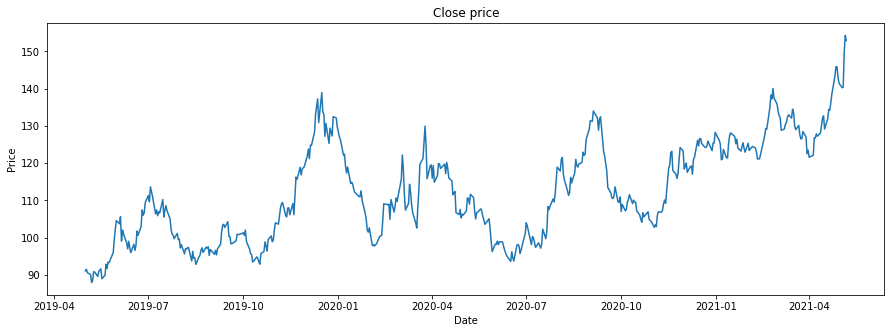

In [8]:
# wykres wartości historycznych
plt.figure(figsize = (15,5))
plt.plot(df.Close)
plt.title('Close price')
plt.xlabel ('Date')
plt.ylabel ('Price')
plt.show()

In [9]:
# Feature Scaling Normalization - normalizacja
scaler = MinMaxScaler()
# normalizacja min-max i skalowanie zmiennych w skali od 0 do 1 
close_price = df['Close'].values.reshape(-1, 1) 
# funkcja skalująca oczekuje argumentów (x, y)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close[~np.isnan(scaled_close)] 
# usuwanie braków NaNs (jeśli występują)
scaled_close = scaled_close.reshape(-1, 1) 
# formatowanie danych po usunięciu NANów 

In [10]:
SEQ_LEN = 100
# tworzenie sekwencji 100 dni w punkcie 0
def to_sequences(data, seq_len):
    d = []
    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])
    return np.array(d)
def preprocess(data_raw, seq_len, train_split):
    data = to_sequences(data_raw, seq_len)
    num_train = int(train_split * data.shape[0])
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]
    return X_train, y_train, X_test, y_test
"""Walidacja postępująca: 
Wstępna długość sekwencji jest określona na 100, dlatego algorytm będzie wykonywać "krok w prawo" i tworzyć nową sekwencję.
Proces będzie się powtarzać do momentu, w którym zostaną wykorzystane wszystkie możliwe pozycje."""
X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.7) 
# 30% danych zachowanych na testy
print(X_train.shape, X_test.shape)
"""Model wykorzyta 287 sekwencji uzwględniających 99 dni (zmian cen) do procesu uczenia. Będzie przewidywać cenę 99 dni do przodu. """   

(287, 99, 1) (123, 99, 1)


'Model wykorzyta 287 sekwencji uzwględniających 99 dni (zmian cen) do procesu uczenia. Będzie przewidywać cenę 99 dni do przodu. '

In [11]:
DROPOUT = 0.2 
# 20% Dropout, by zapobiec przetrenowaniu modelu 
WINDOW_SIZE = SEQ_LEN - 1
model = keras.Sequential()
# warstwa Input 
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
""" Dwukierunkowe RNNy umożliwiają uczenie na wartościach sekwencji wstecz i postępująco"""
model.add(Dropout(rate=DROPOUT))
# 1. warstwa ukryta (1st Hidden layer)
model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True)))
model.add(Dropout(rate=DROPOUT))
# 2nd Hidden layer
model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
# warstwa output 
model.add(Dense(units=1))
model.add(Activation('linear'))
""" Warstwa wyjściowa składa się z pojedynczego neuronu (przewidywanej ceny kawy). Wykorzystano liniową funkcję aktywacyjną."""
BATCH_SIZE = 64
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1) 
# shuffle nie jest zalecane podczas analizy szeregów czasowych


Epoch 1/50
5/5 [==============================] - 25s 2s/step - loss: 0.0971 - val_loss: 0.0105
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.0414 - val_loss: 8.2012e-04
Epoch 3/50
5/5 [==============================] - 5s 1s/step - loss: 0.0182 - val_loss: 0.0051
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.0117 - val_loss: 0.0013
Epoch 5/50
5/5 [==============================] - 6s 1s/step - loss: 0.0160 - val_loss: 0.0019
Epoch 6/50
5/5 [==============================] - 5s 1s/step - loss: 0.0110 - val_loss: 0.0036
Epoch 7/50
5/5 [==============================] - 6s 1s/step - loss: 0.0091 - val_loss: 8.3201e-04
Epoch 8/50
5/5 [==============================] - 5s 1s/step - loss: 0.0099 - val_loss: 0.0015
Epoch 9/50
5/5 [==============================] - 5s 1s/step - loss: 0.0074 - val_loss: 0.0017
Epoch 10/50
5/5 [==============================] - 6s 1s/step - loss: 0.0065 - val_loss: 0.0011
Epoch 11/50
5/5 [=======================

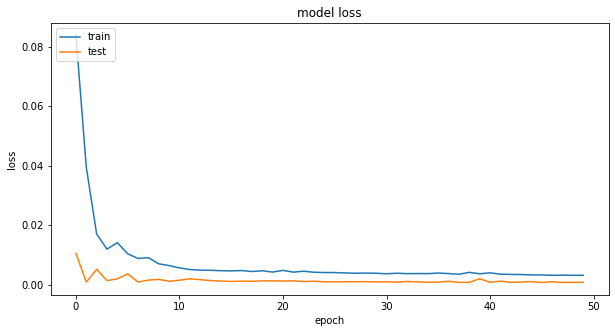

In [12]:
# wykres funkcji LOSS dla zbioru treningowego i testowego
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
# predykcje na zbiorze testowym
y_pred = model.predict(X_test) 
# przekształcenie wartości testowych do oryginalnych
y_test_inverse = pd.DataFrame(scaler.inverse_transform(y_test))
# przypisanie datetime
y_test_inverse.index = df.index[-len(y_test):] 
print('Test data:',)
print(y_test_inverse.tail(7)); print();
#  przekształcenie predykcji na interpretowalne wartości 
y_pred_inverse = pd.DataFrame(scaler.inverse_transform(y_pred)) 
# przypisanie datetime
y_pred_inverse.index = y_test_inverse.index 
print('Prediction data:',)
print(y_pred_inverse.tail(7))

Test data:
                 0
Date              
2021-04-29  145.85
2021-04-30  143.00
2021-05-03  141.45
2021-05-04  140.25
2021-05-05  140.35
2021-05-06  149.85
2021-05-07  154.30

Prediction data:
                     0
Date                  
2021-04-29  134.024323
2021-04-30  135.435852
2021-05-03  135.592102
2021-05-04  135.097031
2021-05-05  134.275604
2021-05-06  133.626877
2021-05-07  135.494995


In [21]:
# sprawdzenie parametrów modelu (MAE, MSE, RMSE, R^2)
print(f'MAE {mean_absolute_error(y_test, y_pred)}')
print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 {r2_score(y_test, y_pred)}')

MAE 0.06256581934938638
MSE 0.0066570231733115775
RMSE 0.08159058262637654
R2 0.5431393917892782


In [22]:
# definiowanie tablicy z datami do predykcji
future = np.arange('2021-05-07', '2021-05-27', dtype='datetime64[D]')
future

array(['2021-05-07', '2021-05-08', '2021-05-09', '2021-05-10',
       '2021-05-11', '2021-05-12', '2021-05-13', '2021-05-14',
       '2021-05-15', '2021-05-16', '2021-05-17', '2021-05-18',
       '2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26'],
      dtype='datetime64[D]')

In [ ]:
# zastosowanie modelu do predykcji dla danych (dat) w powyższej tabeli
